In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [5]:
data_5m = pd.read_csv('data/indicadores_5m.csv')
data_5m

,Timestamp,Close,xg_boost_buy,reg_log_buy,SVC_buy,xg_boost_sell,reg_log_sell,SVC_sell
0,1609778700,129.413299,True,True,True,False,False,True
1,1609779000,129.148498,True,True,True,False,False,True
2,1609779300,128.820007,True,True,True,False,False,True
3,1609779600,128.580001,True,True,True,False,False,True
4,1609779900,128.351699,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...
39537,1672432800,129.054992,True,True,True,False,False,True
39538,1672433100,129.380004,True,True,True,False,False,True
39539,1672433400,129.764404,True,True,True,False,False,True
39540,1672433700,129.949996,True,True,True,False,False,True


In [7]:
data_5m.keys()

Index(['Timestamp', 'Close', 'xg_boost_buy', 'reg_log_buy', 'SVC_buy',
       'xg_boost_sell', 'reg_log_sell', 'SVC_sell'],
      dtype='object')

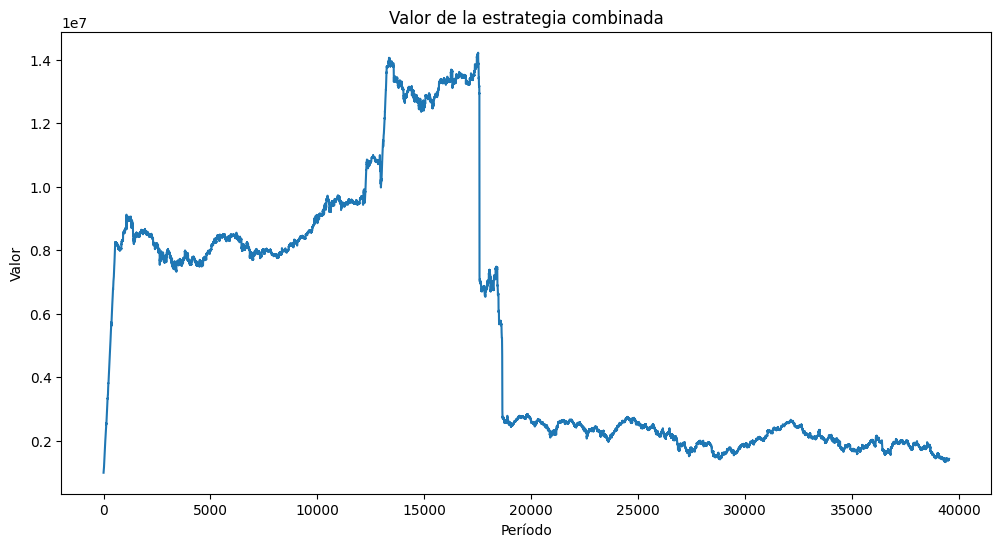

Valor de la estrategia:  1441371.524708725


In [8]:

# Parámetros óptimos
stop_loss_long = 0.13204837666998107
take_profit_long = 0.16924732670477438
stop_loss_short = 0.2481841083567563
take_profit_short = 0.18344160897836873
n_shares_long = 14
n_shares_short = 53

# Variables de la estrategia
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares,
                 stop_loss,take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at =  None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Ejecutar la estrategia
for i, row in data_5m.iterrows():
    # Cerrar operaciones activas
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:  # Cerrar operaciones perdedoras
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:  # Cerrar operaciones con ganancias
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:  # Cerrar operaciones perdedoras
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:  # Cerrar operaciones con ganancias
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    if cash >= row['Close'] * n_shares_long * (1 + com):
                if row['xg_boost_buy']:
                    active_operations.append(Operation(operation_type='Long',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares= n_shares_long,
                                                            stop_loss=(row['Close'] * stop_loss_long),
                                                            take_profit=row['Close'] * (1 + take_profit_long)))
                    cash -= row['Close'] * n_shares_long * (1 + com)

    if cash >= row['Close'] * n_shares_short * (1 + com):

                if row['xg_boost_sell']:
                    active_operations.append(Operation(operation_type='Short',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares=n_shares_short,
                                                            stop_loss=row['Close'] * (1 + stop_loss_short),
                                                            take_profit=row['Close'] * take_profit_short))

                    cash += (op.bought_at - row['Close']) * (1- com) * n_shares_short

    # Valor de la estrategia
    total_value = len(active_operations) * row.Close * (n_shares_short + n_shares_long)
    strategy_value.append(cash + total_value)

# Graficar el valor de la estrategia a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia combinada')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()
print("Valor de la estrategia: ", strategy_value[-1])